In [7]:
from __future__ import division
import keras
import numpy as np
import pandas as pd
from utils import fx_1minute_bar_catalog, load_1minute_fx_bars, logreturn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
#filename = 'moving_average_500_500_500_500_20172901-194204.h5'
filename = 'saves/moving_average_500_500_500_500_20172901-221323.h5'
model = keras.models.load_model(filename)

In [136]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 500)           13000       dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 500)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 500)           250500      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 500)           0           dense_2[0][0]                    
___________________________________________________________________________________________

In [9]:
# TODO: record, exact training history of this model.

# was trained using:
http://localhost:8888/notebooks/fxdata-moving-average-signals.ipynb

In [10]:
catalog = fx_1minute_bar_catalog()
for k in catalog.keys():
    print k, sorted(catalog[k])

EURJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
EURUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
GBPCHF ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
USDJPY ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAUGBP ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
XAGUSD ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


XAUGBP 2014 good
```
0 -24.006137497
1 -18.8588801909
2 2.8667225482
3 26.9078096808
4 22.8008012843
```
XAUUSD 2014
```
0 -29.8168921148
1 -22.4982650542
2 9.87497013618
3 10.3252027896
4 26.3714604262
```

XAUUSD 2015
```
0 -60.9791955775
1 -20.3033646518
2 -5.24774211161
3 22.307311691
4 29.0843892895
```

EURJPY 2015
```
0 -2.80814288973
1 -5.45890309854
2 -0.382935895543
3 1.27519156188
4 3.5130369436
```

GBPUSD 2015
```
0 -0.00624628916692
1 -0.0588986113089
2 0.0142498676861
3 0.0232730017919
4 0.00491347882038
```

In [113]:
ds = load_1minute_fx_bars('GBPUSD', 2015)[['close']]
#ds['close'] = 1/ds['close']

In [114]:
def ewmasig(x, lp, sp):
    volp = lp*5
    lma = x.ewm(span=lp).mean()
    sma = x.ewm(span=sp).mean()
    return np.tanh(15000 * (sma - lma) * lma.ewm(volp).std() / (np.sqrt(lp) *sma.ewm(volp).std()))

def masig(x, lp, sp):
    volp = lp*5
    lma = x.rolling(lp).mean()
    sma = x.rolling(sp).mean()
    return np.tanh(10000 * (sma - lma) * lma.rolling(volp).std() / (np.sqrt(lp) *sma.rolling(volp).std()))

In [115]:
px = logreturn(ds['close'], ds['close'].shift(1)).cumsum()
ds['px'] = px
for period in [2,4,8,16,32,64,128,256]:
    ds['lret-{}'.format(period)] = np.tanh(logreturn(px, px.shift(period)))
    ds['ma{}-{}'.format(2*period, period)] = masig(px, 2*period, period)
    ds['ewma{}-{}'.format(2*period, period)] = ewmasig(px, 2*period, period)


In [116]:
price = ds['close']
ds = ds.drop('close',axis=1).fillna(0.0)

In [117]:
ds.shape

(372231, 25)

In [118]:
%%time
pred = model.predict(ds.as_matrix())

CPU times: user 1min 21s, sys: 4.65 s, total: 1min 25s
Wall time: 29.6 s


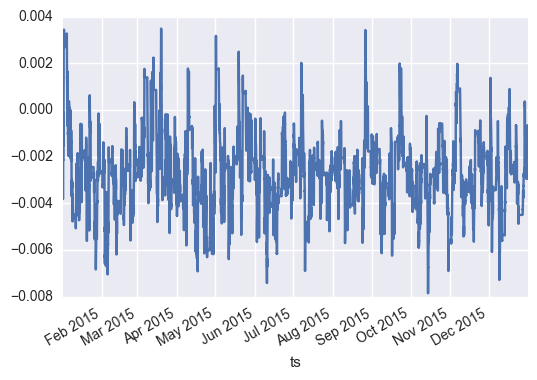

In [119]:
idx = ds.index
plt.figure()#figsize=(20,12))
#pp = pd.Series((-2*pred[:,0] + -1*pred[:,1] + 1*pred[:,3] + 2*pred[:,4]), index=idx)
pp = pd.Series((-1*pred[:,0]  + 1*pred[:,4]), index=idx)
pp.ewm(1000).mean().plot()

In [120]:
fut_return = price.shift(-10)- price
fut_return.mean()

-2.2708552177335477e-06

sig 1.0121943684e-05
ewma: 1 7.92416333307e-06
ma: 1 1.0121943684e-05
ewma: 2 6.93501978663e-06
ma: 2 8.67033294736e-06
ewma: 3 6.10852155037e-06
ma: 3 7.75195381239e-06
ewma: 4 5.45901494005e-06
ma: 4 7.17321161353e-06
ewma: 5 4.74427826479e-06
ma: 5 6.84577173238e-06
ewma: 6 4.10105824228e-06
ma: 6 6.71493548188e-06
ewma: 7 4.06038348186e-06
ma: 7 6.35928655288e-06
ewma: 8 4.04485507266e-06
ma: 8 5.90213878314e-06
ewma: 9 4.06930291413e-06
ma: 9 5.71740981836e-06


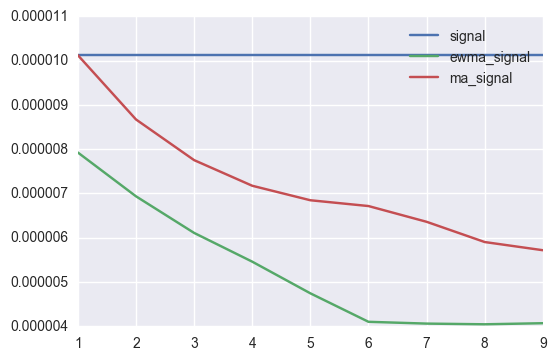

In [121]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).mean()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).mean()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).mean()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

In [122]:
fut_return.std()

0.00066981761018125

sig 0.000669744976605
ewma: 1 0.000669774585344
ma: 1 0.000669744976605
ewma: 2 0.000669785557531
ma: 2 0.000669765341617
ewma: 3 0.000669793605203
ma: 3 0.000669776600634
ewma: 4 0.000669799213781
ma: 4 0.000669783048907
ewma: 5 0.000669804657695
ma: 5 0.000669786475669
ewma: 6 0.000669808904825
ma: 6 0.000669787800148
ewma: 7 0.000669809152631
ma: 7 0.000669791271272
ewma: 8 0.000669809246584
ma: 8 0.000669795455621
ewma: 9 0.000669809098502
ma: 9 0.000669797057954


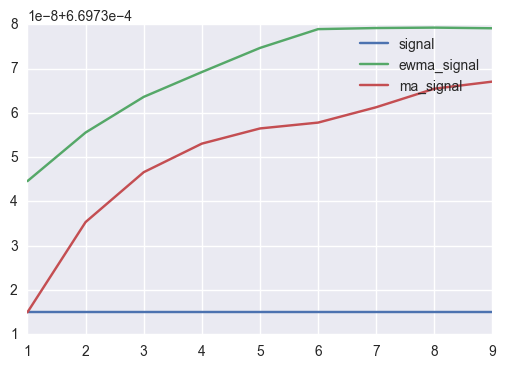

In [123]:
ewma_sx = []
ma_sx = []
sx = []
idxs = []
success = (fut_return * (((pp > 0)*2)-1)  ).std()
print "sig", success

for i in range(1,10):
    ewma_success = (fut_return *  (((pp.ewm(i).mean() > 0)*2)-1)  ).std()
    print "ewma:",i, ewma_success
    ewma_sx.append(ewma_success)
    ma_success = (fut_return * (((pp.rolling(i).mean() > 0)*2)-1) ).std()
    ma_sx.append(ma_success)
    print "ma:",i, ma_success
    sx.append(success)
    idxs.append(i)
plt.plot(idxs, sx, label='signal')
plt.plot(idxs, ewma_sx, label='ewma_signal')
plt.plot(idxs, ma_sx, label='ma_signal')
plt.legend()

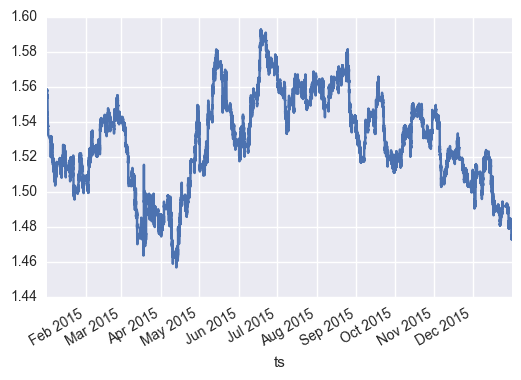

In [124]:
price.plot()

- expected return
- trading cost. frequency


In [125]:
print sx

[0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301, 0.0006697449766045301]


----------------------

In [126]:
pred.max(axis=0)

array([ 0.3695561 ,  0.26397374,  0.59318876,  0.26583561,  0.37446481], dtype=float32)

In [127]:
np.argmax(pred, axis=1)

array([2, 2, 2, ..., 3, 3, 3])

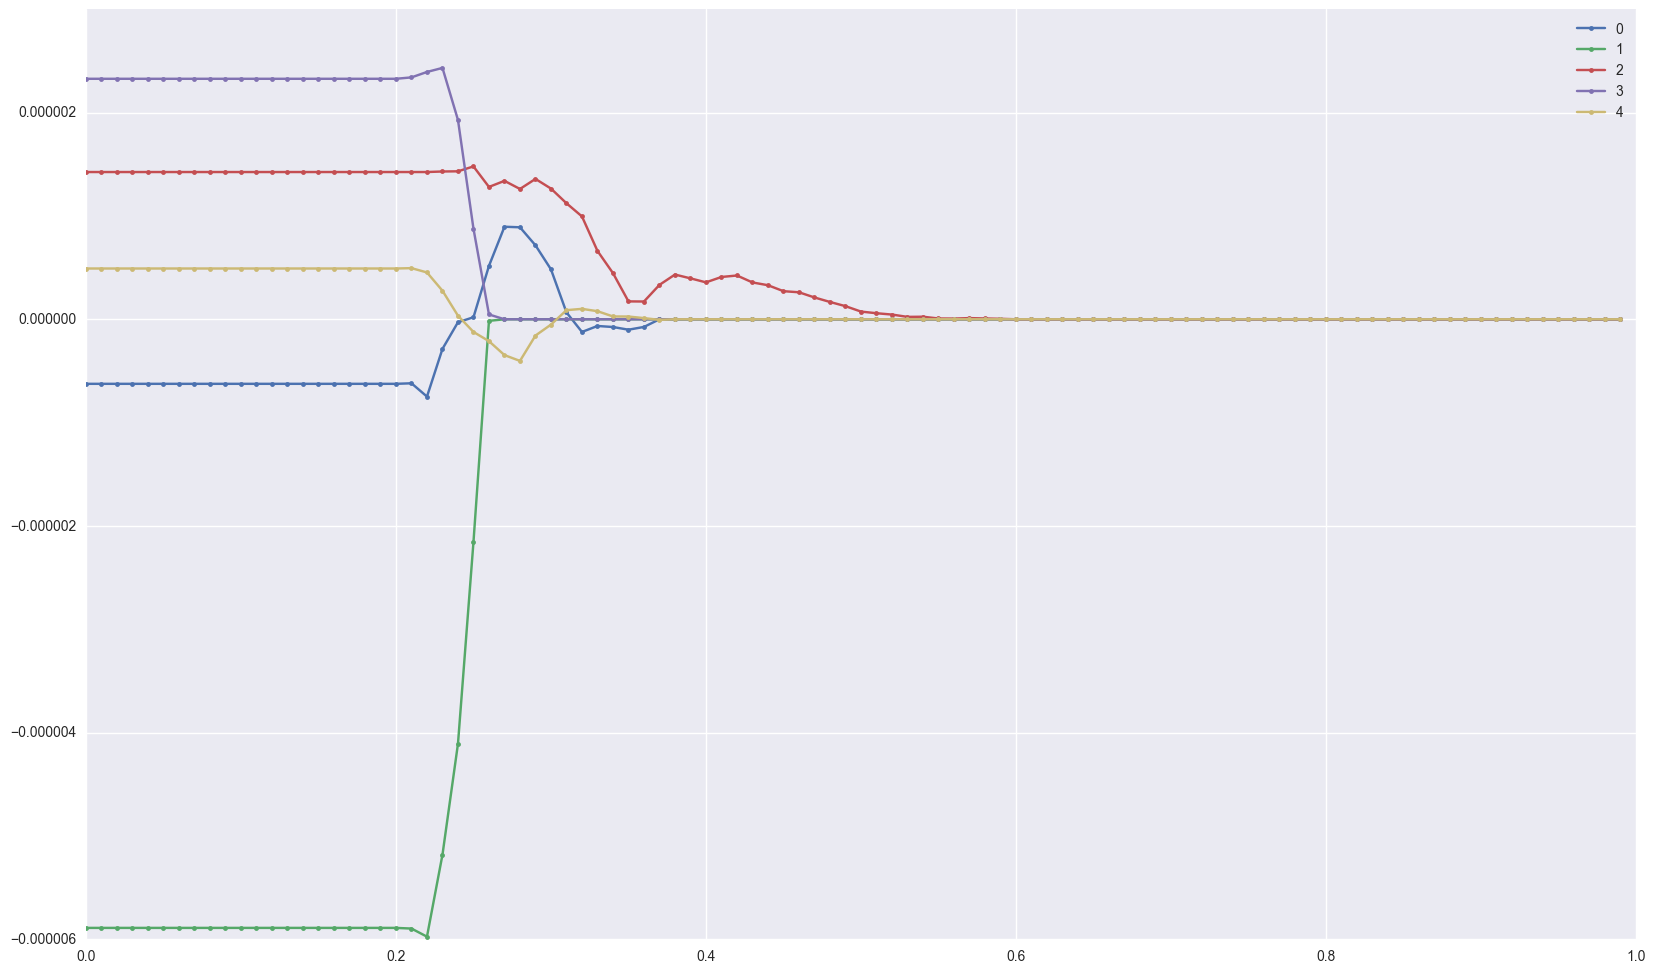

In [128]:
FIGSIZE = (20,12)
plt.figure(figsize=FIGSIZE)
STEPS = 100
for idx in range(5):
    fracs  = []
    results = []
    for i in range (STEPS):
        frac = i/STEPS
        result = ((np.argmax(pred, axis=1) == idx) * (pred[:,idx] > frac) * fut_return).mean()
        #result = ((np.argmax(pred, axis=1) == idx) *  fut_return).mean()
        fracs.append(frac)
        results.append(result)
    #print fracs, results
    plt.plot(fracs,results,'.-', label=str(idx))
plt.legend()
plt.show()
    

In [129]:
pred_categories = np.argmax(pred, axis=1)

In [130]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()

0 -0.00624628916692
1 -0.0588986113089
2 0.0142498676861
3 0.0232730017919
4 0.00491347882038


In [131]:
for i in range(5):
    print i, 1e4*(fut_return * (pred_categories == i)).mean()
 

0 -0.00624628916692
1 -0.0588986113089
2 0.0142498676861
3 0.0232730017919
4 0.00491347882038


1001.44384774


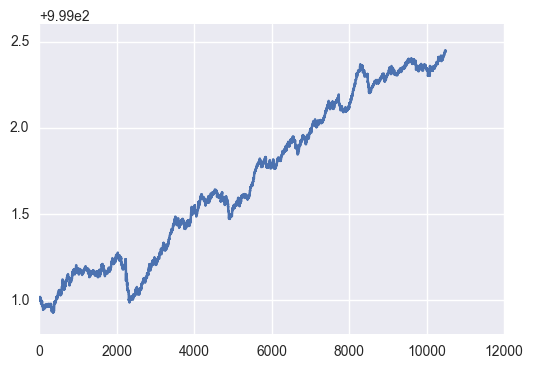

In [134]:
INITIAL = 1000.0
RISK = 0.005
balance = INITIAL
holdings = 0
holding_period=10
countdown = 0
BPS = 1e-4
cost = 0 * BPS
bals = []

idx = ds.index
for i in range(len(idx)):
    prediction = pp[i]
    prx = price[i]
    amt = balance * RISK / prx

    #print i, prediction,prx
    if countdown == 0 and holdings == 0:

        if prediction > 0:
            balance -= prx *(1+cost) * amt
            holdings += amt
            #print "bought",amt,"at",prx 
        else:
            balance += prx *(1-cost)* amt
            holdings -= amt
            #print "sold",amt,"for",prx 
        countdown = holding_period
    elif countdown == 0:
        # dispose of assets if prediction opposite to current holding
        if np.sign(prediction) != np.sign(holdings):
            balance += prx * holdings
            # print "disposed of ", holdings, "at", prx,". balance=", balance
            holdings = 0
            bals.append(balance)
    else:
        countdown -= 1

# dispose of any holdings, before reporting final balance:
if holdings !=0:
    balance += prx * holdings
    holdings = 0
    bals.append(balance)
    
print balance
plt.plot(bals)

In [135]:
(bals[-1] - bals[0]) / np.array(bals).std()

3.0541287674951687